In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sentence_transformers import SentenceTransformer
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import KNNImputer

In [32]:
data = pd.read_csv("comms.csv")

In [33]:
# Drop unnecessary columns (e.g., 'Unnamed: 0')
data = data.drop(columns=['Unnamed: 0'], errors='ignore')

In [34]:
#checking null values
data.isnull().sum()

User1 ID            0
User2 ID            0
Message             0
Label               0
Peerness        33748
Age_User1           0
Gender_User1        0
Grade_User1         0
Age_User2           0
Gender_User2        0
Grade_User2         0
dtype: int64

In [35]:
data.head()

,User1 ID,User2 ID,Message,Label,Peerness,Age_User1,Gender_User1,Grade_User1,Age_User2,Gender_User2,Grade_User2
0,1,2,bye bye dear bajaj i got some better work to ...,1,0.5,11,Others,5,15,Male,9
1,1,2,Haha your so funny you sit on wikipedia all da...,1,0.5,11,Others,5,15,Male,9
2,1,2,My problem is people talking out of their asse...,1,0.5,11,Others,5,15,Male,9
3,1,2,Article updated,0,0.5,11,Others,5,15,Male,9
4,1,2,Well arent you phucking special Its easy to ha...,1,0.5,11,Others,5,15,Male,9


In [36]:
data["Gender_User1"].value_counts()

Gender_User1
Others    35593
Male      28746
Female    26017
Name: count, dtype: int64

In [39]:
data.head()

,User1 ID,User2 ID,Message,Label,Peerness,Age_User1,Gender_User1,Grade_User1,Age_User2,Gender_User2,Grade_User2
0,1,2,bye bye dear bajaj i got some better work to ...,1,0.5,11,Others,5,15,Male,9
1,1,2,Haha your so funny you sit on wikipedia all da...,1,0.5,11,Others,5,15,Male,9
2,1,2,My problem is people talking out of their asse...,1,0.5,11,Others,5,15,Male,9
3,1,2,Article updated,0,0.5,11,Others,5,15,Male,9
4,1,2,Well arent you phucking special Its easy to ha...,1,0.5,11,Others,5,15,Male,9


In [40]:
#filling the null values
# KNN Imputation for 'Peerness'
imputer_knn = KNNImputer(n_neighbors=5)
data['Peerness'] = imputer_knn.fit_transform(data[['Peerness', 'Age_User1', 'Grade_User1', 'Age_User2', 'Grade_User2']])[:, 0]

# Linear Interpolation for Demographic Features
data['Age_User1'] = data['Age_User1'].interpolate(method='linear')
data['Grade_User1'] = data['Grade_User1'].interpolate(method='linear')
data['Age_User2'] = data['Age_User2'].interpolate(method='linear')
data['Grade_User2'] = data['Grade_User2'].interpolate(method='linear')

# For Gender columns, fill missing with the most frequent value (mode)
data['Gender_User1'] = data['Gender_User1'].fillna(data['Gender_User1'].mode()[0])
data['Gender_User2'] = data['Gender_User2'].fillna(data['Gender_User2'].mode()[0])
data['Label'] = data['Label'].fillna(data['Label'].mode()[0])

In [6]:
#checking null values again
data.isnull().sum()

User1 ID        0
User2 ID        0
Message         0
Label           0
Peerness        0
Age_User1       0
Gender_User1    0
Grade_User1     0
Age_User2       0
Gender_User2    0
Grade_User2     0
dtype: int64

In [7]:
# Encode categorical data (e.g., gender)
label_encoder = LabelEncoder()
data['Gender_User1'] = label_encoder.fit_transform(data['Gender_User1'])
data['Gender_User2'] = label_encoder.fit_transform(data['Gender_User2'])

In [ ]:
#Prepare the features (X) and target (y)
X_text = data['Message']
X_other = data[['Peerness', 'Age_User1', 'Gender_User1', 'Grade_User1', 'Age_User2', 'Gender_User2', 'Grade_User2']]
y = data['Label']

In [8]:
# Load a more advanced Sentence Transformer model
model = SentenceTransformer('all-mpnet-base-v2')

# Generate embeddings using Sentence Transformers
X_bert = model.encode(X_text.tolist(), batch_size=32, show_progress_bar=True)

# Combine Sentence Transformer embeddings with other features
X_other = X_other.values  # Already in NumPy
X = np.concatenate((X_bert, X_other), axis=1)

Batches:   0%|          | 0/2824 [00:00<?, ?it/s]

Batches:   0%|          | 0/2824 [00:00<?, ?it/s]

Accuracy: 0.8320606463036742
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.93      0.88     11949
           1       0.83      0.64      0.72      6123

    accuracy                           0.83     18072
   macro avg       0.83      0.78      0.80     18072
weighted avg       0.83      0.83      0.83     18072



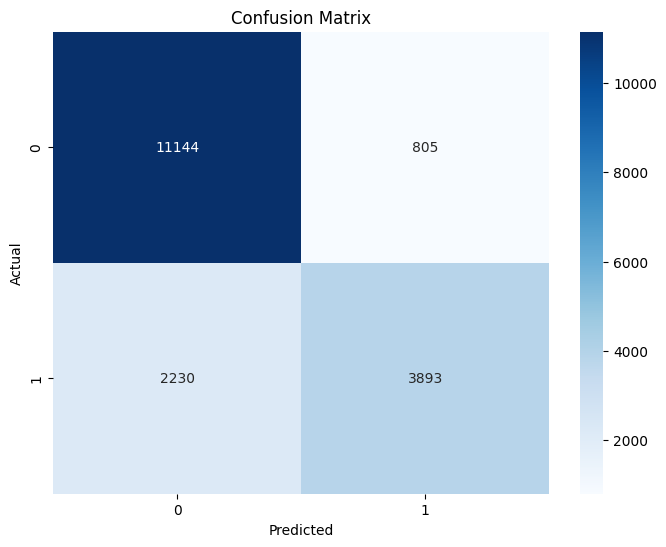

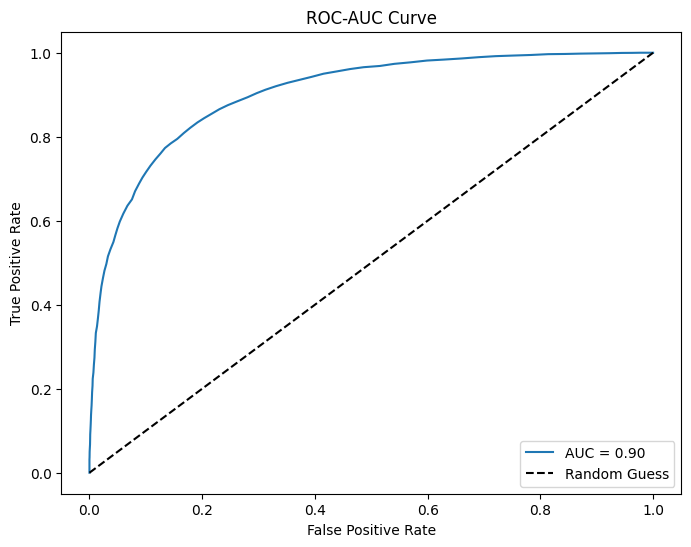

Model training and evaluation complete.


In [9]:
data['Gender_User1'] = label_encoder.fit_transform(data['Gender_User1'])
data['Gender_User2'] = label_encoder.fit_transform(data['Gender_User2'])

# Prepare the features (X) and target (y)
X_text = data['Message']
X_other = data[['Peerness', 'Age_User1', 'Gender_User1', 'Grade_User1', 'Age_User2', 'Gender_User2', 'Grade_User2']]
y = data['Label']

# Load a Sentence Transformer model
model = SentenceTransformer('all-mpnet-base-v2')

# Generate embeddings using Sentence Transformers
X_bert = model.encode(X_text.tolist(), batch_size=32, show_progress_bar=True)

# Combine Sentence Transformer embeddings with other features
X_other = torch.tensor(X_other.values, dtype=torch.float32).numpy()
X = torch.cat((torch.tensor(X_bert, dtype=torch.float32), torch.tensor(X_other, dtype=torch.float32)), dim=1).numpy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC-AUC Curve
if len(set(y)) == 2:  # Ensure binary classification
    y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.title('ROC-AUC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

print("Model training and evaluation complete.")

In [10]:
import pickle
#rf_classifier
# Save the model to a pickle file
with open("rf_classifier.pkl", "wb") as file:
    pickle.dump(rf_classifier, file)

print("Model saved successfully!")


Model saved successfully!


In [25]:
print(X)

[[-2.0230534e-03  5.4870073e-02  6.2591839e-03 ...  1.5000000e+01
   1.0000000e+00  9.0000000e+00]
 [-1.6108572e-02 -2.6718383e-03 -8.6295174e-04 ...  1.5000000e+01
   1.0000000e+00  9.0000000e+00]
 [ 2.5028579e-02  2.2251308e-02  1.7488819e-02 ...  1.5000000e+01
   1.0000000e+00  9.0000000e+00]
 ...
 [-7.6337188e-02 -6.3727781e-02 -2.2422740e-02 ...  1.1000000e+01
   2.0000000e+00  5.0000000e+00]
 [ 5.2903280e-02  7.4711353e-02  1.6974088e-02 ...  1.1000000e+01
   2.0000000e+00  5.0000000e+00]
 [ 3.3134352e-02 -5.1647803e-04 -1.9208174e-02 ...  1.1000000e+01
   2.0000000e+00  5.0000000e+00]]


In [ ]:
df = pd.DataFrame(X)


,0,1,2,3,4,5,6,7,8,9,...,765,766,767,768,769,770,771,772,773,774
0,-0.002023,0.054870,0.006259,-0.019992,0.034919,0.015071,-0.018653,0.010870,0.032670,0.027647,...,0.053671,-0.048528,-0.030951,0.500000,11.0,2.0,5.0,15.0,1.0,9.0
1,-0.016109,-0.002672,-0.000863,0.037819,-0.065893,0.031889,0.053769,-0.011411,-0.000803,-0.057249,...,0.012386,-0.070722,-0.018946,0.500000,11.0,2.0,5.0,15.0,1.0,9.0
2,0.025029,0.022251,0.017489,0.042093,-0.026620,0.038498,0.043656,-0.008131,-0.003406,-0.023669,...,-0.000825,0.011040,0.009676,0.500000,11.0,2.0,5.0,15.0,1.0,9.0
3,0.040421,0.033772,-0.003494,0.036805,-0.027148,-0.026709,0.024270,0.005401,-0.085529,0.005906,...,-0.033975,-0.031095,-0.024594,0.500000,11.0,2.0,5.0,15.0,1.0,9.0
4,-0.016108,0.120450,0.018368,0.030502,-0.004955,0.035231,0.023442,0.008867,-0.041787,-0.003354,...,0.050852,-0.049883,0.006604,0.500000,11.0,2.0,5.0,15.0,1.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90351,0.008833,0.023735,0.016739,-0.020688,-0.036289,0.009519,0.087638,-0.002253,-0.082870,-0.014801,...,0.029380,0.001395,-0.002505,0.300000,17.0,2.0,11.0,10.0,2.0,4.0
90352,0.051956,0.037648,-0.014386,0.024688,0.022484,0.029536,0.023159,-0.015548,-0.019776,0.020237,...,0.016940,-0.051764,0.018165,0.366667,17.0,2.0,11.0,11.0,2.0,5.0
90353,-0.076337,-0.063728,-0.022423,0.005369,0.010351,-0.043015,0.039479,0.037826,-0.001273,0.005045,...,0.011327,-0.034329,-0.050542,0.366667,17.0,2.0,11.0,11.0,2.0,5.0
90354,0.052903,0.074711,0.016974,0.069155,-0.001405,0.032729,0.005891,-0.065419,-0.040606,-0.003502,...,0.005786,-0.003353,0.011487,0.366667,17.0,2.0,11.0,11.0,2.0,5.0


In [ ]:
ts = pd.read_csv("unbiased.csv")
ts.head()

In [ ]:
X_train_ts, X_test_ts, y_train_ts, y_test_ts = train_test_split(ts, train_size = 0.6, random_state = 42)
rfc_ts = RandomForestClassifier(random_state=42)
rfc_ts.fit(X_train_ts,y_train_ts)